In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # type: ignore

In [2]:
import pandas as pd

data = pd.read_csv("spam.csv")
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [4]:
df_ham = data[data['Category']=='ham']
df_ham.shape

(4825, 2)

In [5]:
df_spam = data[data['Category']=='spam']
df_spam.shape

(747, 2)

In [6]:
df_ham_balanced_sample = df_ham.sample(df_spam.shape[0])
df_ham_balanced_sample.shape

(747, 2)

In [7]:
data_balanced = pd.concat([df_ham_balanced_sample,df_spam])
data_balanced.shape

(1494, 2)

In [8]:
data_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [9]:
data_balanced['spam'] = data_balanced['Category'].apply(lambda x: 1 if x =='spam' else 0 )
data_balanced.sample(5)

,Category,Message,spam
4386,spam,Do you want a New Nokia 3510i Colour Phone Del...,1
1887,spam,Dear 0776xxxxxxx U've been invited to XCHAT. T...,1
5046,ham,We have sent JD for Customer Service cum Accou...,0
3821,ham,"I got arrested for possession at, I shit you n...",0
5229,ham,It means u could not keep ur words.,0


In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data_balanced['Message'],data_balanced['spam'],stratify=data_balanced['spam'])

In [11]:
y_train.sample(5)

302     0
2384    0
3876    0
5080    0
3056    1
Name: spam, dtype: int64

In [12]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1')

In [13]:
def sentence_encoder(sentence):
    pre_text = bert_preprocess(sentence)
    return bert_encoder(pre_text)['pooled_output']

sentence_encoder([
    'hello this is run check.',
    'this is second sentence for check'
])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.9933621 ,  0.97333205,  0.12884618, ...,  0.32036042,
        -0.13694291,  0.05297787],
       [ 0.9914664 ,  0.10464615,  0.18319288, ...,  0.34871274,
        -0.28150967, -0.2708791 ]], dtype=float32)>

In [19]:
word = sentence_encoder([
    'apple',
    'banana',
    'cycle',
    'bus',
    'shirt',
    'horse',
    'dog',
    'cat',
    'lion'
])

In [20]:
word

<tf.Tensor: shape=(9, 512), dtype=float32, numpy=
array([[ 0.96825767,  0.4494403 , -0.18196331, ..., -0.15019338,
        -0.62235266,  0.217308  ],
       [ 0.9842703 ,  0.30940858,  0.16240574, ...,  0.11738293,
        -0.4507025 ,  0.02611814],
       [ 0.99402857,  0.43966502, -0.20077421, ...,  0.14415649,
        -0.4184864 , -0.7595779 ],
       ...,
       [ 0.99534273,  0.827905  ,  0.1358913 , ...,  0.45941687,
        -0.5692647 , -0.75793713],
       [ 0.9962467 , -0.35754102, -0.26992577, ...,  0.39836317,
        -0.70694643, -0.4790373 ],
       [ 0.99591   ,  0.11346842, -0.01134887, ..., -0.13424905,
        -0.5127904 ,  0.07381982]], dtype=float32)>

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([word[1]],[word[8]])

array([[0.90586483]], dtype=float32)

In [31]:
# bert Layer
input_text = tf.keras.layers.Input(shape=(),dtype=tf.string, name='text')
preprocess_text = bert_preprocess(input_text)
output = bert_encoder(preprocess_text)

# neural network layer
drop = tf.keras.layers.Dropout(0.1, name = 'dropout')(output['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name = 'output')(drop)

model = tf.keras.Model(inputs=[input_text], outputs=[l])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [36]:
MATRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics= MATRICS
)

In [37]:
model.fit(x_train,y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 51s 1s/step - loss: 0.1774 - accuracy: 0.9554 - recall: 0.9625 - precision: 0.9489
Epoch 2/5
35/35 [==============================] - 54s 2s/step - loss: 0.1573 - accuracy: 0.9500 - recall: 0.9554 - precision: 0.9452
Epoch 3/5
35/35 [==============================] - 52s 1s/step - loss: 0.1381 - accuracy: 0.9563 - recall: 0.9518 - precision: 0.9604
Epoch 4/5
35/35 [==============================] - 52s 1s/step - loss: 0.1306 - accuracy: 0.9598 - recall: 0.9625 - precision: 0.9574
Epoch 5/5
35/35 [==============================] - 53s 2s/step - loss: 0.1207 - accuracy: 0.9634 - recall: 0.9625 - precision: 0.9642


In [35]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 14s 1s/step - loss: 0.2211 - accuracy: 0.0000e+00 - recall: 0.9572 - precision: 0.9227


[0.22112777829170227, 0.0, 0.9572192430496216, 0.9226804375648499]

In [38]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()


Caching the list of root modules, please wait!
Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

12/12 [==============================] - 19s 1s/step


In [39]:
import numpy as np

y_predicted = np.where(y_predicted >0.5, 1,0)
y_predicted

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,

In [40]:
from sklearn.metrics import confusion_matrix,classification_report

cm = confusion_matrix(y_test,y_predicted)
cm

array([[176,  11],
       [  8, 179]], dtype=int64)

Text(50.722222222222214, 0.5, 'True Value')

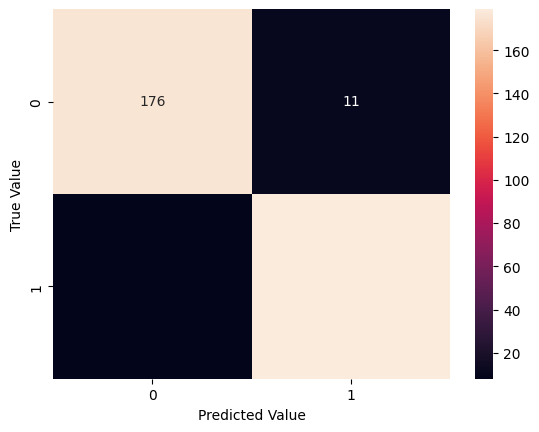

In [41]:
from matplotlib import pyplot as plt 
import seaborn as sns

sns.heatmap(cm, annot = True,fmt='d')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')


In [42]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       187
           1       0.94      0.96      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374

